## Install Requirements
******Remember to restart the kernel after installing

In [1]:
%pip install --upgrade pip
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.
Ignoring tensorflow: markers 'sys_platform == "linux"' don't match your environment
Ignoring tensorflow: markers 'sys_platform == "windows"' don't match your environment
Ignoring tensorflow-macos: markers 'sys_platform == "darwin"' don't match your environment
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, sys, shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

## Process the videos into frames

In [3]:
def calc_median(frames):
    median_frame = np.median(frames, axis=0).astype(dtype=np.uint8)
    return median_frame

In [40]:
def extractImages(pathIn, pathOut, leakRange, nonleakRange):

  '''
  Input:
    String: pathIn should be the path of the video 
    String: pathOut should be the path of the folder where the name of the folder is the name of the video
    Tuple: range of leak frames from video
    Tuple: range of nonleak frames from video

  Output:
    creates two subfolders in pathOut called Leaks and Nonleaks
      Leaks folder contains the frames where there are leaks
      Nonleaks folder contains the frames where there are noleaks
  '''

  leakPath = os.path.join(pathOut, "Leak")
  nonleakPath = os.path.join(pathOut, "Nonleaks")
  
  os.makedirs(leakPath, exist_ok=True)
  os.makedirs(nonleakPath, exist_ok=True)

  def helper(pathIn, pathOut, range, isleak):
    '''
    Might need to clean this up, but this was extracted from the original extractImages from the previous implementation
    
    '''
    # count = range[0]

    #getting start and end of range (end is inclusive)
    start = range[0] 
    end = range[1] + 1
    #setting up moving average list
    prev_imgs = []
    prev_limit = 10 #210 in paper
    #setting start of video to the start frame
    vidcap = cv2.VideoCapture(pathIn)
    vidcap.set(cv2.CAP_PROP_POS_MSEC, (start))
    #reading frame
    success,image = vidcap.read()
    success = True
    X_design = []

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    prev_imgs.append(image)
    median_img = calc_median(prev_imgs)
    image = cv2.absdiff(image, median_img)
    image = image.reshape(*(image.shape), 1)
    X_design.append(np.array(image))
    start += 15
    if vidcap.isOpened():
      while success and start < end:
          # vidcap.set(cv2.CAP_PROP_POS_MSEC, (start*1000))    # added this line 
          vidcap.set(cv2.CAP_PROP_POS_MSEC, (start))
          success, image = vidcap.read()
          if success:
            #print ('Read a new frame: ', count, " ,isleak: ", isleak)
            # label = 0

            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            prev_imgs.append(image)

            if len(prev_imgs) > prev_limit:
                prev_imgs.pop(0)

            median_img = calc_median(prev_imgs)
            image = cv2.absdiff(image, median_img)
            image = image.reshape(*(image.shape), 1)

            if isleak:
              cv2.imwrite(os.path.join(pathOut, "leak.frame%d.jpg" % start), image)     # save frame as JPEG file
              label = 1
            else:
              cv2.imwrite(os.path.join(pathOut, "nonleak.frame%d.jpg" % start), image)
            X_design.append(np.array(image))
            start += 15
          else:
            print ('Error at frame: ', start, " ,isleak: ", isleak)
            break
      vidcap.release()
    cv2.destroyAllWindows()
    return np.stack(X_design)
  # call helper for both leak and nonleak
  X_leak = helper(pathIn, leakPath, leakRange, True)
  y_leak = np.ones(X_leak.shape[0])
  X_nonleak = helper(pathIn, nonleakPath, nonleakRange, False)
  y_nonleak = np.zeros(X_nonleak.shape[0])

  X = np.concatenate((X_leak, X_nonleak), axis=0)
  y = np.concatenate((y_leak, y_nonleak), axis=0)
  
  return X, y

### Get the images now

In [52]:
# get generic path to directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

# get all raw video data directories
data_dir = os.path.join(dir_path, 'data')

train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

frame_data_dir = os.path.join(dir_path, 'frame_data_debug')
frame_train_data_dir = os.path.join(frame_data_dir, 'train')
frame_test_data_dir = os.path.join(frame_data_dir, 'test')

In [6]:
raw_data = np.loadtxt(os.path.join(dir_path, 'GasVid_Ranges.csv'), skiprows=1, delimiter=',', dtype=int)

ranges = list(zip(raw_data[:, 0], raw_data[:, 1:3], raw_data[:, 3:5])) #need to upload new ranges
ranges = {ranges[i][0] : (ranges[i][1], ranges[i][2]) for i in range(len(ranges))}
len(ranges)

25

In [24]:
ranges

{2564: (array([ 465, 2865]), array([ 3165, 22065])),
 2559: (array([ 660, 3060]), array([ 3360, 22260])),
 2560: (array([ 480, 2880]), array([ 3180, 22080])),
 2561: (array([ 510, 2910]), array([ 3210, 22110])),
 2562: (array([ 585, 2985]), array([ 3285, 22185])),
 1242: (array([ 300, 2700]), array([ 3000, 21900])),
 1237: (array([ 510, 2910]), array([ 3210, 22110])),
 1238: (array([ 285, 2685]), array([ 2985, 20985])),
 1239: (array([ 300, 2700]), array([ 3000, 21900])),
 1240: (array([ 330, 2730]), array([ 3030, 21930])),
 2566: (array([ 495, 2895]), array([ 3195, 22095])),
 2567: (array([ 330, 2730]), array([ 3030, 21930])),
 2568: (array([ 225, 2625]), array([ 2580, 21480])),
 2569: (array([ 480, 2880]), array([ 3180, 22080])),
 2570: (array([ 675, 3075]), array([ 3375, 22275])),
 2578: (array([ 615, 3015]), array([ 3315, 22215])),
 2579: (array([ 480, 2880]), array([ 3180, 22080])),
 2580: (array([ 630, 3030]), array([ 3330, 22230])),
 2581: (array([ 645, 3045]), array([ 3345, 222

In [13]:
def read_frames_from_dir(dir_path, output_path, image_dim, max_vids=None):
    cur_count = 1
    X_train, y_train = np.array([], dtype=np.int64).reshape(0, image_dim[0], image_dim[1], 1), []
    for file in os.listdir(dir_path):
        if max_vids and cur_count > max_vids:
            break
        vid_path = os.path.join(dir_path, file)
        vid_id = int(os.path.basename(vid_path)[4:8])
        if vid_id not in ranges.keys():
            continue
        nonleak_start = ranges[vid_id][0][0]
        nonleak_end = ranges[vid_id][0][1]
        leak_start = ranges[vid_id][1][0]
        leak_end = ranges[vid_id][1][1]

        X_vid, y_vid = extractImages(vid_path, output_path, (leak_start, leak_end), (nonleak_start, nonleak_end))
        print("Video", vid_id, X_vid.shape)
        X_train = np.concatenate((X_train, X_vid), axis=0)
        y_train.append(y_vid)
        print('Done with', cur_count, "video(s)")
        cur_count += 1
    y_train = np.concatenate(y_train, axis=0) # improve time complexity
    return X_train, y_train

In [53]:
image_dim = (240, 320)
vid_count = 8
test_count = 4

X_train, y_train = read_frames_from_dir(train_data_dir, frame_train_data_dir, image_dim, vid_count)
print("Done with Training Data")
X_test, y_test = read_frames_from_dir(test_data_dir, frame_test_data_dir, image_dim, test_count)
print("Done with Testing Data")
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Video 1237 (1422, 240, 320, 1)
Done with 1 video(s)
Done with Training Data
Video 1467 (1422, 240, 320, 1)
Done with 1 video(s)
Video 1468 (1422, 240, 320, 1)
Done with 2 video(s)
Video 1469 (1422, 240, 320, 1)
Done with 3 video(s)


KeyboardInterrupt: 

In [15]:
from keras import layers 
from keras import models 

model = models.Sequential() 

# Conv Pool 1
model.add(layers.Conv2D(4, (3, 3), input_shape=(240, 320, 1)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Conv Pool 2
model.add(layers.Conv2D(8, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Conv Pool 3
model.add(layers.Conv2D(8, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Conv Pool4
model.add(layers.Conv2D(4, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(2400, activation='relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 318, 4)       40        
                                                                 
 batch_normalization (BatchN  (None, 238, 318, 4)      16        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 238, 318, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 159, 4)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 119, 159, 4)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 8)       2

In [ ]:
# from keras import layers 
# from keras import models 

# model = models.Sequential() 
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(240, 320, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2))) 
# model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
# model.add(layers.MaxPooling2D((2, 2))) 
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2))) 
# model.add(layers.Flatten()) 
# model.add(layers.Dense(512, activation='relu')) 
# model.add(layers.Dense(1, activation='sigmoid')) 

# model.summary()

In [ ]:
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_train[0]

In [16]:
val_split = 0.2
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=val_split, stratify=y_train)

X = np.concatenate((X_t, X_v))
y = np.concatenate((y_t, y_v))

In [17]:
nonleaks = len(y) - sum(y)
leaks = sum(y)
total = len(y)

weight_nonleak = (1 / nonleaks) * (total / 2.0)
weight_leak = (1 / leaks) * (total / 2.0)

class_weight = {0: weight_nonleak, 1: weight_leak}

In [18]:
class_weight

{0: 4.392857142857142, 1: 0.5642201834862385}

In [19]:
from keras import optimizers 
from keras import metrics

def F1Score(y_true, y_pred):
    prec = metrics.Precision()
    recall = metrics.Recall()
    prec.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    prec_res = prec.result().numpy()
    rec_res = recall.result().numpy()
    return 2 * (prec_res * rec_res) / (prec_res + rec_res)

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=[F1Score, "acc"], run_eagerly=True)


In [20]:
def sample_weights(data):
    weights = []
    zero_sum = 0
    for image in data:
        summed_pixels = np.sum(image)
        if summed_pixels == 0:
            weights.append(0)
            zero_sum += 1
        else:
            # try using sqrt transformation for weight skew
            # weights.append(1 / np.sqrt(summed_pixels))
            weights.append(1 / summed_pixels)
    median_weight = np.median(weights)
    weights = [median_weight if weight == 0 else weight for weight in weights]
    # print(zero_sum) # debugging
    return weights

In [21]:
X_train_weights = sample_weights(X_train)

In [22]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

# for now, dont do augmentation
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1. / 255,
    validation_split=val_split,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.05,
)

train_datagen.fit(X)

train_flow = train_datagen.flow(
    X, y, 
    # sample_weight = X_train_weights,
    # target_size=(150, 150), 
    batch_size=batch_size,
    # class_mode='binary',
    subset='training'
)

val_flow = train_datagen.flow(
    X, y, 
    # target_size=(150, 150), 
    batch_size=batch_size,
    # class_mode='binary',
    subset='validation'
)

In [23]:
num_epochs = 5

history = model.fit_generator(
    train_flow, 
    epochs=num_epochs, 
    validation_data=val_flow, 
    validation_steps=1,
    class_weight=class_weight
)


model.save('leak_and_nonleak_roy.h5')

C:\Users\bestlab\AppData\Local\Temp\ipykernel_2528\536072036.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
283/283 [==============================] - 151s 532ms/step - loss: 0.7396 - F1Score: 0.6078 - acc: 0.4830 - val_loss: 0.6980 - val_F1Score: nan - val_acc: 0.1562
Epoch 2/5


C:\Users\bestlab\AppData\Local\Temp\__autograph_generated_file96o26um4.py:18: RuntimeWarning: invalid value encountered in double_scalars
  retval_ = 2 * (ag__.ld(prec_res) * ag__.ld(rec_res)) / (ag__.ld(prec_res) + ag__.ld(rec_res))


283/283 [==============================] - 151s 532ms/step - loss: 0.7021 - F1Score: 0.5118 - acc: 0.4043 - val_loss: 0.6945 - val_F1Score: nan - val_acc: 0.1250
Epoch 3/5
283/283 [==============================] - 151s 531ms/step - loss: 0.6980 - F1Score: nan - acc: 0.2111 - val_loss: 0.6948 - val_F1Score: nan - val_acc: 0.0938
Epoch 4/5
283/283 [==============================] - 151s 532ms/step - loss: 0.6984 - F1Score: nan - acc: 0.2357 - val_loss: 0.6947 - val_F1Score: nan - val_acc: 0.0625
Epoch 5/5
283/283 [==============================] - 152s 536ms/step - loss: 0.6978 - F1Score: nan - acc: 0.1803 - val_loss: 0.6944 - val_F1Score: nan - val_acc: 0.1875


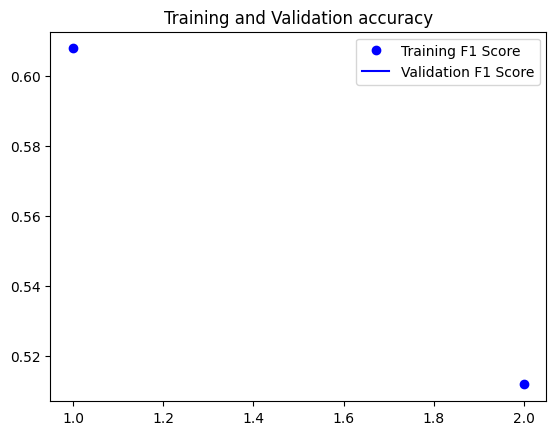

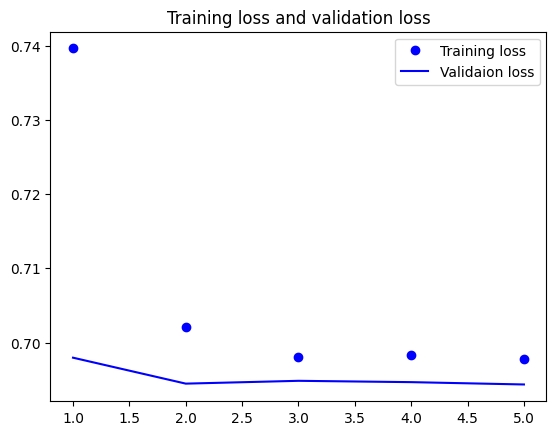

In [25]:
import matplotlib.pyplot as plt 

f1 = history.history['F1Score'] 
val_f1 = history.history['val_F1Score'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(f1) + 1) 

plt.plot(epochs, f1, 'bo', label='Training F1 Score') 
plt.plot(epochs, val_f1, 'b', label='Validation F1 Score') 
plt.title('Training and Validation accuracy') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validaion loss') 
plt.title('Training loss and validation loss') 
plt.legend() 

plt.show() 

## Testing

In [26]:
test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1. / 255,
)

test_datagen.fit(X_test)

test_flow = test_datagen.flow(
    X_test,
    batch_size=batch_size,
    shuffle=False,
    
)

In [33]:
test_flow[0].shape

(32, 240, 320, 1)

In [39]:
test_flow[0][0]

array([[[-0.40506488],
        [-0.40506488],
        [-0.40506488],
        ...,
        [-0.40506488],
        [-0.40506488],
        [-0.40506488]],

       [[-0.40506488],
        [-0.40506488],
        [-0.40506488],
        ...,
        [-0.40506488],
        [-0.40506488],
        [-0.40506488]],

       [[-0.40506488],
        [-0.40506488],
        [-0.40506488],
        ...,
        [-0.40506488],
        [-0.40506488],
        [-0.40506488]],

       ...,

       [[-0.40506488],
        [-0.40506488],
        [-0.40506488],
        ...,
        [-0.40506488],
        [-0.40506488],
        [-0.40506488]],

       [[-0.40506488],
        [-0.40506488],
        [-0.40506488],
        ...,
        [-0.40506488],
        [-0.40506488],
        [-0.40506488]],

       [[-0.40506488],
        [-0.40506488],
        [-0.40506488],
        ...,
        [-0.40506488],
        [-0.40506488],
        [-0.40506488]]], dtype=float32)

In [38]:
cv2.imshow("image", test_flow[0][0].astype('uint8'))

In [27]:
predictions = model.predict(test_flow)

176/176 [==============================] - 19s 106ms/step


In [28]:
processed_preds = (predictions >= 0.5).flatten().astype(int)

In [29]:
test_acc = np.sum(processed_preds == y_test) / len(y_test)
print(f'Test Accuracy is {test_acc} after training for {num_epochs} epochs on {len(y_test)} test images')

Test Accuracy is 0.11442786069651742 after training for 5 epochs on 5628 test images


In [30]:
leak_indices = [i for i in range(len(y_test)) if y_test[i] == 1]
nonleak_indices = [i for i in range(len(y_test)) if y_test[i] == 0]
leak_predictions, leak_y_test = processed_preds[leak_indices], y_test[leak_indices]
nonleak_predictions, nonleak_y_test = processed_preds[nonleak_indices], y_test[nonleak_indices]

leak_test_acc = np.sum(leak_predictions == leak_y_test) / len(leak_y_test)
nonleak_test_acc = np.sum(nonleak_predictions == nonleak_y_test) / len(nonleak_y_test)
print(f'Leak Test accuracy is {leak_test_acc} after training for {num_epochs} epochs on {len(leak_y_test)} leak test images')
print(f'Non-Leak Test accuracy is {nonleak_test_acc} after training for {num_epochs} epochs on {len(nonleak_y_test)} non-leak test images')


Leak Test accuracy is 0.0 after training for 5 epochs on 4984 leak test images
Non-Leak Test accuracy is 1.0 after training for 5 epochs on 644 non-leak test images


## Below is legacy code appendix

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,       #
    width_shift_range=0.2,   # 
    height_shift_range=0.2,  # 
    shear_range=0.2,         # 
    zoom_range=0.2,          # 
    horizontal_flip=True,    # 
    fill_mode='nearest'      # 
)

# 
from keras.preprocessing import image 
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]
img_path = fnames[3]  # 
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)  # 
x = x.reshape((1, ) + x.shape)  # 

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i) 
    i += 1
    imgplot = plt.imshow(array_to_img(batch[0])) 
    if i % 4 == 0:
        break 
plt.show() 

In [ ]:
model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Flatten()) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255) 
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary'
)

history = model.fit_generator(  
    
    train_generator, 
    steps_per_epoch=1, 
    epochs=30, 
    validation_data=validation_generator, 
    validation_steps=1
)

# Save
model.save('leak_and_nonleak_2.h5') 

In [ ]:
import matplotlib.pyplot as plt 

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and Validation accuracy') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validaion loss') 
plt.title('Training and validation loss') 
plt.legend() 

plt.show() 

In [ ]:
f1 = r'/Users/ianchen/Desktop/MethaneCNN/test/frame3018.jpg'  # nonleak
f2 = r'/Users/ianchen/Desktop/MethaneCNN/test/frame4414.jpg'  # leak

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img

img_path = f2
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)  # 
x = x.astype('float32') / 255
x = x.reshape((1, ) + x.shape)  # 

res = model.predict(x)  # 
leak_acc = 1 - res[0][0]
leak_acc

In [ ]:
import matplotlib.pyplot as plt 
from keras.preprocessing import image 
from keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img

model = load_model('./leak_and_nonleak_2.h5')
image_path = r'./test/frame4404.jpg'  # 
original_image = load_img(image_path)

img = load_img(image_path, target_size=(150, 150))
x = img_to_array(img) 
x = x.astype('float32') / 255 
x = x.reshape((1, ) + x.shape) 

res = model.predict(x)
res = res[0][0]
acc = 1- res

text = 'leak'
if res > 0.5:
    text = 'nonleak'
plt.imshow(original_image)
plt.axis("off")
plt.text(30, 40, text, fontdict=dict(fontsize=30, color='r',
            family='monospace',#
            weight='bold',#
            )#
)
plt.show()

In [ ]:
acc